# LSTM Bot

## Project Overview

In this project, you will build a chatbot that can converse with you at the command line. The chatbot will use a Sequence to Sequence text generation architecture with an LSTM as it's memory unit. You will also learn to use pretrained word embeddings to improve the performance of the model. At the conclusion of the project, you will be able to show your chatbot to potential employers.

Additionally, you have the option to use pretrained word embeddings in your model. We have loaded Brown Embeddings from Gensim in the starter code below. You can compare the performance of your model with pre-trained embeddings against a model without the embeddings.



---



A sequence to sequence model (Seq2Seq) has two components:
- An Encoder consisting of an embedding layer and LSTM unit.
- A Decoder consisting of an embedding layer, LSTM unit, and linear output unit.

The Seq2Seq model works by accepting an input into the Encoder, passing the hidden state from the Encoder to the Decoder, which the Decoder uses to output a series of token predictions.

## Dependencies

- Pytorch
- Numpy
- Pandas
- NLTK
- Gzip
- Gensim


Please choose a dataset from the Torchtext website. We recommend looking at the Squad dataset first. Here is a link to the website where you can view your options:

- https://pytorch.org/text/stable/datasets.html





In [1]:
test = False
init = False
all = False
hidden_sizes = {'small':50, 'large':100}
hidden_size = hidden_sizes['large']

if test:
    !pip install -U  pytest
if init:
    pass
    #!pip install torchsummary
    #!pip install typing-extensions --upgrade
    #!pip install -U torch torchvision torchtext torchdata pytest
    #!pip install bcolz

In [2]:
#!pip install bcolz

In [3]:
# public libraries
import nltk
import numpy as np
import pandas as pd
import gzip
import torch
import torch.nn as nn
import pandas as pd
import torch.optim
import random
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
#from sklearn.model_selection import KFold
from pathlib import Path
from nltk.stem import PorterStemmer
from pathlib import Path

from torch.nn.utils import weight_norm as wn

# my libraries
import src.utils
import src.data
import gensim
import pickle

import bcolz
import string
from src.utils import clean_text

In [4]:
words = []
idx = 0
word2idx = {}
glove_path = "data"

print(init)
if init:
    vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.{hidden_size}.dat', mode='w')
    with open(f'{glove_path}/glove.6B.{hidden_size}d.txt', 'rb') as f:
        for l in f:
            line = l.decode().split()
            word = line[0]
            words.append(word)
            word2idx[word] = idx
            idx += 1
            vect = np.array(line[1:]).astype(np.float)
            vectors.append(vect)

    vectors = bcolz.carray(vectors[1:].reshape((400000, 100)), rootdir=f'{glove_path}/6B.{hidden_size}.dat', mode='w')
    vectors.flush()
    pickle.dump(words, open(f'{glove_path}/6B.{hidden_size}_words.pkl', 'wb'))
    pickle.dump(word2idx, open(f'{glove_path}/6B.{hidden_size}_idx.pkl', 'wb'))
#
vectors = bcolz.open(f'{glove_path}/6B.{hidden_size}.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.{hidden_size}_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.{hidden_size}_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}



False


In [5]:

# from nltk.corpus import brown
# from nltk.tokenize import RegexpTokenizer



# #from ntlk.stem import *

# #nltk.download('brown')
# #nltk.download('punkt')

# # Output, save, and load brown embeddings

# #model = gensim.models.Word2Vec(brown.sents())
# #model.save('brown.embedding')

# w2v = gensim.models.Word2Vec.load('brown.embedding')



# def loadDF(path):
#   '''

#   You will use this function to load the dataset into a Pandas Dataframe for processing.

#   '''
#   return df


# def prepare_text(sentence):

#     '''

#     Our text needs to be cleaned with a tokenizer. This function will perform that task.
#     https://www.nltk.org/api/nltk.tokenize.html

#     '''

#     return tokens



# def train_test_split(SRC, TRG):

#     '''
#     Input: SRC, our list of questions from the dataset
#             TRG, our list of responses from the dataset

#     Output: Training and test datasets for SRC & TRG

#     '''
#     share = 0.2
#     src_split = len(SRC)*share
#     trg_split = len(TRG)*share
#     SRC_test_dataset = SRC[:scr_split]
#     SRC_train_dataset = SRC[scr_split:]
#     TRG_test_dataset = SRC[:trg_split]
#     TRG_train_dataset = SRC[trg_split:]


#     return SRC_train_dataset, SRC_test_dataset, TRG_train_dataset, TRG_test_dataset
# print(w2v.wv['the'],len(w2v.wv['the']))

### Get and watch the data

In [6]:
if init:
    src.data.squad1_to_csv()
    
df_train = pd.read_csv('data/train_dataset_squad1.csv')  
# df_train = pd.read_csv('data/poc_data.csv')  
df_test = pd.read_csv('data/dev_dataset_squad1.csv') 
# df_test = pd.read_csv('data/poc_data.csv')
split = round(len(df_train)*100/(len(df_train)+len(df_test)),1)
print(f"{len(df_train)} training samples and {len(df_test)} have been loaded.")
print(f"The trainig data makes {split}% of all the data.")
df_train.head()
#if all == False:
#    df_train = df_train[:5000]

87599 training samples and 10570 have been loaded.
The trainig data makes 89.2% of all the data.


,Unnamed: 0,context,question,answer,answer_start
0,0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,['Saint Bernadette Soubirous'],[515]
1,1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,['a copper statue of Christ'],[188]
2,2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,['the Main Building'],[279]
3,3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,['a Marian place of prayer and reflection'],[381]
4,4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,['a golden statue of the Virgin Mary'],[92]


### Data Analysis

(array([1.8320e+03, 3.0516e+04, 3.6537e+04, 1.4233e+04, 3.5570e+03,
        7.1700e+02, 1.5700e+02, 3.8000e+01, 1.0000e+01, 2.0000e+00]),
 array([ 1. ,  4.9,  8.8, 12.7, 16.6, 20.5, 24.4, 28.3, 32.2, 36.1, 40. ]),
 <BarContainer object of 10 artists>)

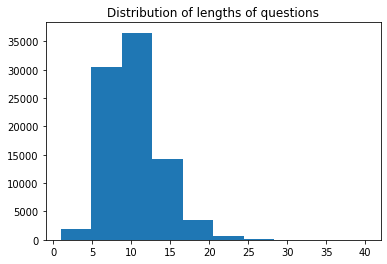

In [7]:
raw_questions = [clean_text(s) for s in df_train["question"].values.tolist()]
raw_answers = [clean_text(q[2:-2]) for q in df_train["answer"].values.tolist()]
# Source Data
plt.title("Distribution of lengths of questions")
plt.hist(np.array([len(n) for n in raw_questions]))


(array([7.2082e+04, 9.7980e+03, 2.9480e+03, 1.6730e+03, 6.6700e+02,
        3.5300e+02, 7.6000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ]),
 <BarContainer object of 10 artists>)

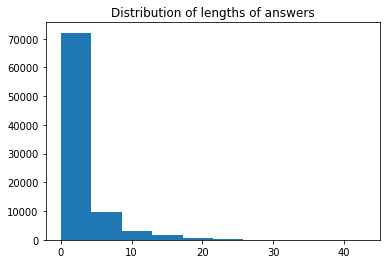

In [8]:
# Target Data
plt.title("Distribution of lengths of answers")
plt.hist(np.array([len(n) for n in raw_answers]))

### Filtering out of noise

In [9]:
if all == True:
    t1 = 25
    t2 = 13
else:
    t1 = 19
    t2 = 10
index_a = [index for index, row in enumerate(raw_questions) if len(row) < t1]
index_b = [index for index, row in enumerate(raw_answers) if len(row) < t2]


# index_a = [index for index, row in enumerate(raw_questions) if len(row) > 1]
# index_b = [index for index, row in enumerate(raw_answers) if len(row) > 4]


index_all=list(set(index_a).intersection(set(index_b)))
share = round(((len(df_train)-len(index_all))/len(df_train))*100,1)
df_train_filtered = df_train.iloc[index_all]
print(f"We have removed {share}% of the data.")

We have removed 7.6% of the data.


In [10]:
# we have to repeat this step with the filtered dataframe
raw_questions = [clean_text(s) for s in df_train_filtered["question"].values.tolist()]
raw_answers = [clean_text(q[2:-2]) for q in df_train_filtered["answer"].values.tolist()]

### Tokenization

In [11]:
vocab_prep = src.utils.Vocab(name='prep')
vocab_source = src.utils.Vocab(name='source')
vocab_target = src.utils.Vocab(name='target')


count = 0
for q, a in zip(raw_questions, raw_answers):

    PAD = "<PAD>"
    SOS = "<SOS>"
    EOS = "<EOS>"
    OUT = "<OUT>"
    special_tokens = ["<PAD>", "<SOS>", "<EOS>", "<OUT>"]
    for word in special_tokens + q:
        vocab_source.indexWord(word)
    for word in special_tokens + a:
        vocab_target.indexWord(word)

print("source:", len(vocab_source.words), "target:", len(vocab_target.words), "common words:", len(list(set(vocab_source.words.keys()).intersection(set(vocab_target.words.keys())))))

questions = src.utils.tokenize_questions(raw_questions, vocab_source)
answers = src.utils.tokenize_answers(raw_answers, vocab_target)


source: 38324 target: 37575 common words: 20557


### Tests

In [12]:
if test:
    !python -m pytest -vv srctests.py

### Defining the model

In [21]:

import torch.nn as nn
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, vocab, glove,dropout=0):
        
        super(Encoder, self).__init__()
        
        # self.embedding provides a vector representation of the inputs to our model
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        weights_matrix = np.zeros((input_size, hidden_size))
        words_found = 0
        for i, word in enumerate(vocab.words):
            try: 
                weights_matrix[i] = glove[word]
                words_found += 1
            except KeyError:
                weights_matrix[i] = np.random.normal(scale=0.6, size=(hidden_size, ))
        print(f"For {words_found} of {len(vocab.words)} words an entry has been found in glove.")
        
        weights_matrix = torch.from_numpy(weights_matrix)
        self.embedding.load_state_dict({'weight':weights_matrix})
        
        # self.lstm, accepts the vectorized input and passes a hidden state
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        
    
    def forward(self, i, h):
        
        '''
        Inputs: i, the src vector
        Outputs: o, the encoder outputs
                h, the hidden state (actually a tuple of hidden state and cell state)
        '''
        embedding = self.embedding(i)
        x,y = h
        o, h= self.lstm(embedding, h)
        o = self.dropout(o)
        
        return o, h
    

class Decoder(nn.Module):
      
    def __init__(self, hidden_size, output_size, vocab, glove,dropout):
        
        super(Decoder, self).__init__()
        
        # self.embedding provides a vector representation of the target to our model
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        weights_matrix = np.zeros((output_size, hidden_size))
        words_found = 0
        for i, word in enumerate(vocab.words):
            try: 
                weights_matrix[i] = glove[word]
                words_found += 1
            except KeyError:
                weights_matrix[i] = np.random.normal(scale=0.6, size=(hidden_size, ))
        
        weights_matrix = torch.from_numpy(weights_matrix)
        self.embedding.load_state_dict({'weight':weights_matrix})
        
        # self.lstm, accepts the embeddings and outputs a hidden state
        self.lstm = nn.LSTM(hidden_size, hidden_size)

        # self.ouput, predicts on the hidden state via a linear output layer  
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(p=dropout)
        
        #self.softmax = nn.Softmax(dim=1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, i, h):
        
        '''
        Inputs: i, the target vector
        Outputs: o, the decoder output
                h, the hidden state (actually a tuple of hidden state and cell state)
        '''

        embedding = self.embedding(i)

        o, h = self.lstm(embedding, h)

        o = self.linear(o)
        
        o = self.dropout(o)

        o = self.softmax(o)

        
        return o, h
        
        

class Seq2Seq(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, vocab_source, vocab_target, glove, dropout_E=0, dropout_D=0, teacher_forcing_ratio=1,certain=True):
        
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, vocab_source, glove, dropout_E)
        self.decoder = Decoder(hidden_size, output_size, vocab_target, glove,dropout_D)
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.certain = certain
        #self.softmax = nn.LogSoftmax(dim=1)
                
        
    
    
    def forward(self, src, trg, start): 
        '''
        Inputs: src, the source vector
                trg, the target vector
        Outputs: o, the prediction
                
        '''
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        src.to(device)
        trg.to(device)
        start.to(device)
        
            
        
        # encoder
        hidden = (torch.zeros(1,hidden_size).to(device), torch.zeros(1,hidden_size).to(device))
        for word in src:
            #print("word",word.shape,word)
            o, hidden = self.encoder(word.view(-1).to(device), hidden)
            x,y = hidden

        
        # decoder
        o = start
        #rprint(trg)
        
        prediction = []
        for word in trg:

            o, hidden = self.decoder(o.view(-1).to(device), hidden)
            x,y = hidden


            
            if self.training == False:
                if self.certain:             
                    #print(o)
                    o = torch.argmax(o,dim=1)
                    #print(o)
                #else:
                #    o = torch.LongTensor(random.choices(list(range(len(o[0]))), weights=(o[0].detach().cpu().apply_(lambda x: np.exp(x))), k=1))[0]                                                                              
                
            prediction.append(o)
            
            if self.training:
                o = word if random.random() < self.teacher_forcing_ratio else torch.argmax(o,dim=1)
                #o = word if random.random() < self.teacher_forcing_ratio else torch.LongTensor(random.choices(list(range(len(o))), weights=(o.detach().cpu().apply_(lambda x: np.exp(x))), k=1))[0]
                                                    
                



        prediction = torch.stack(prediction)

        prediction = prediction.squeeze()

        return prediction

    



### Training

In [ ]:



questions = src.utils.tokenize_questions(raw_questions, vocab_source)
answers = src.utils.tokenize_answers(raw_answers, vocab_target)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_cuda = torch.cuda.is_available()
#is_cuda = False
print(f"Computing on {device}.")


# hyperparams
epochs = 5
batch_size = 64
print_each = 30

lr = 0.1
weight_decay = 0.0
penalize_early_eos = 1 # the smaller the higher the penalty, i.e. the less the weight

#hidden_size is defined at the very top
teacher_forcing_ratio = 0.5 # the higher the teacher_forcing_ratio, the easier it is to learn
dropout_E=0.5
dropout_D=0.0






split = int(0.98*len(questions))
batches = len(questions[:split]) // batch_size



# model
input_size = len(vocab_source.words)
hidden_size = hidden_size
output_size = len(vocab_target.words)
model = Seq2Seq(input_size, hidden_size, output_size, vocab_source, vocab_target, glove, dropout_E, dropout_D, teacher_forcing_ratio=teacher_forcing_ratio)


v = "submission"
if Path(f"checkpoints/model_{v}.pt").is_file():
    model.load_state_dict(torch.load(f"checkpoints/model_{v}.pt", map_location=torch.device('cpu')))
    print(f"loading from checkpoint: 'checkpoints/model_{v}.pt'")
else:
    print(f"nothing to load at checkpoint: 'checkpoints/model_{v}.pt'")
v="submission"




model.to(device)
# training


optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
weight = torch.Tensor([1]*output_size).to(device)
weight[2]=penalize_early_eos
loss_fn = nn.NLLLoss(weight=weight)

epoch = 0
missed = 0
for epoch in range(epochs):
    train_loss = 0
    for i, (batch_q, batch_a) in enumerate(zip(src.utils.heteroDataLoader(questions[:split],batch_size), src.utils.heteroDataLoader(answers[:split],batch_size))):   
        #print(i,"yes")
        # training loop
        model.train()
        batch_loss = 0

        for m, (q, a) in enumerate(zip(batch_q, batch_a)):  
            start = next(iter(torch.LongTensor([vocab_target.words["<SOS>"]])))
            start.to(device)
            a=a.to(device)
            q=q.to(device)
            output = model(q,a,start)
            output.to(device)
            model.to(device)
            try:
                loss = loss_fn(output,a)
            except:
                print(f"Loss could not be computed for: {output} with shape {output.shape}.")
                print(f"Question: {q}")
                print(f"Answer: {a}")
                print(f"Old loss will be used with the value of {loss}.")
                loss = loss
                
            batch_loss += loss

        batch_loss = batch_loss/batch_size
        batch_loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss+=batch_loss
   
        #print(i)
        if i % print_each== 0:
            print("batch:", f"{i}/{batches}")

    
            
        if i % (print_each * 2) == 0:
            valid_loss = 0
            for n, (batch_q, batch_a) in enumerate(zip(src.utils.heteroDataLoader(questions[split:],batch_size), src.utils.heteroDataLoader(answers[split:],batch_size))):     
                # evaluation loop
                model.eval()
                batch_loss = 0
                for q, a in zip(batch_q, batch_a):      
                    start = next(iter(torch.LongTensor([vocab_target.words["<SOS>"]])))
                    q,a,start = q.to(device),a.to(device),start.to(device)
                    assert len(q.shape) ==1, f"Answer must be 1-dimensional. But {q.shape}"
                    assert len(a.shape) ==1, f"Answer must be 1-dimensional. But {a.shape}"
                    output = model(q,a,start)
                    try:
                        loss = loss_fn(output,a)
                    except:
                        missed = missed +1
#                         print(f"Loss could not be computed for: {output} with shape {output.shape}.")
#                         print(f"Question: {q}")
#                         print(f"Answer: {a}")
#                         print(f"Old loss will be used with the value of {loss}.")
                        loss = loss
                    batch_loss += loss
 
                valid_loss += batch_loss / batch_size
            valid_loss = round(valid_loss.item() / (len(questions[split:])//batch_size),3)
            train_loss = round(train_loss.item() / ((i+1)*5),3)

            print(" ")
            
            print("epoch:", epoch,"batch:", f"{i}/{batches}","train_loss:",train_loss, "valid_loss", valid_loss)
            text = ""
            for x in q:
                text += vocab_source.index[str(x.item())] + " "
            print("question:",text)
            text = ""
            for x in a:
                text += vocab_target.index[str(x.item())] + " "
            print("answer:", text)
            text = ""
            for x in output:
                text += vocab_target.index[str(torch.argmax(x,dim=0).item())] + " "
            print("prediction:", text)
            torch.save(model.state_dict(),f"checkpoints/model_{v}.pt")
            print(f"{missed}/{print_each * 2 * batch_size} samples could not be considered.")
            print("Saved model.")
            print("")
            missed = 0
            train_loss = 0
            
            
                  


            

Computing on cuda.
For 31355 of 38324 words an entry has been found in glove.
nothing to load at checkpoint: 'checkpoints/model_sbumission.pt'
batch: 0/1238
 
epoch: 0 batch: 0/1238 train_loss: 2.119 valid_loss 10.619
question: <SOS> what is durga called in nepali <EOS> 
answer: 170 <EOS> 
prediction: <PAD> <PAD> 
1600/3840 samples could not be considered.
Saved model.

batch: 30/1238
batch: 60/1238


### Evaluate

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = len(vocab_source.words)
hidden_size = hidden_size
output_size = len(vocab_target.words)
teacher_forcing_ratio = 0 # the higher the teacher_forcing_ratio, the easier it is to learn
dropout=0.5
model = Seq2Seq(input_size, hidden_size, output_size, vocab_source, vocab_target, glove, dropout)

v= "current"


if Path(f"checkpoints/model_{v}.pt").is_file():
    model.load_state_dict(torch.load(f"checkpoints/model_{v}.pt", map_location=torch.device('cpu')))
    print(f"loading from checkpoint: 'checkpoints/model_{v}.pt'")
else:
    print(f"nothing to load at checkpoint: 'checkpoints/model_{v}.pt'")

model.to(device)

In [ ]:
from numpy import unravel_index
for i,a in enumerate(model.parameters()):
    if i ==10:
        weights = a.detach().cpu().numpy().flatten()
        print(unravel_index(a.cpu().argmax(), a.shape))
        
plt.hist(weights)
print(min(weights),max(weights))

from numpy import unravel_index
unravel_index(weights.argmax(), weights.shape)
print(weights[277])

In [ ]:
plt.hist(list(model.parameters())[10][2].cpu().detach().numpy())

In [15]:
model.eval()
model.certain=False
print(model.certain, model.training)

# forward(self, src, trg, start, teacher_forcing_ratio = 0.5):
def answer(model, question, answer=None,max_length=15, vocab=vocab_target):
    """
    renders predictions untill the end of sequence or 15...
    """
    try:
        max_length = len(answer)
    except:
        max_length
    src = question
    dummy = [0]*max_length
    trg = torch.LongTensor(dummy)
    start = next(iter(torch.LongTensor([vocab.words["<SOS>"]])))

    predicted_indices=model(src, trg, start)

    predicted_words = [vocab.index[str(a.item())] for a in predicted_indices]
    truncated_sequence =[]
    for word in predicted_words:
        truncated_sequence.append(word)
        if word == "<EOS>":
            break
    predicted_answer =  " ".join(truncated_sequence)
    #print("question:", str([vocab_source.index[str(a)] for a in question.tolist()[0]]))
    if answer != None:
        answer = " ".join([vocab.index[str(a.item())] for a in answer])
        print("answer:",answer)
    print("predicted_answer:",predicted_answer)
    print("")
    



for i in [12000,35,2000,-10,-5]:
    answer(model, questions[i].view(1,-1),answers[i], 5)



False False
answer: nasrani <EOS>
predicted_answer: hinayana 59

answer: theodore m hesburgh library <EOS>
predicted_answer: november saturday 1347 aluminiumdoped venetian

answer: popular 19thcentury piano anthologies <EOS>
predicted_answer: redeem 1600 electrostatically movements eugenio

answer: tribhuvan international airport <EOS>
predicted_answer: women 1759 french footnote

answer: oregon <EOS>
predicted_answer: 133 testing



### Chatbot

In [ ]:

while True:
    q = input()
    q = clean_text(q)
    #hallo mein freund
    q=src.utils.tokenize_questions([q], vocab_source)[0]
    question = [vocab_source.index[str(a)] for a in q.tolist()]
    print(f"So you are saying: {question} ?")
    a = answer(model, q, max_length=10, vocab=vocab_target)
    print(a)